In [98]:
import train_embeddings
import sentence_features
import pickle
from model import ClassificationModel
from random import shuffle
from sklearn.metrics import precision_recall_fscore_support, roc_curve, auc, precision_recall_curve, f1_score, average_precision_score
import matplotlib.pyplot as plt
import numpy as np
import itertools

In [107]:
# Load mapped reports
use_all = True

if not use_all:
    labeled_reports_path = "../data/processed/processed_reports/impression"
    mapped_reports = pickle.load(open(labeled_reports_path, 'rb'))   
else:
    paths = ["../data/processed/processed_reports/impression", "../data/processed/processed_reports/zsfg_valid", "../data/processed/processed_reports/ucsf_test_impression"]
    mapped_reports = [pickle.load(open(p, 'rb')) for p in paths]
    mapped_reports = list(itertools.chain.from_iterable(mapped_reports))

shuffle(mapped_reports)

In [108]:
split_point = int(0.92 * len(mapped_reports))
train = mapped_reports[:split_point]
test = mapped_reports[split_point:]

train_data = [" ".join(t[0]) for t in train]
train_labels = [t[1] for t in train]
test_data = [" ".join(t[0]) for t in test]
test_labels = [t[1] for t in test]

print(len(train))
print(len(test))
print(np.unique(train_labels, return_counts=True))
print(np.unique(test_labels, return_counts=True))

163978
14260
(array([0, 1]), array([130231,  33747]))
(array([0, 1]), array([11352,  2908]))


In [109]:
# Train classifier
dim = 120
model = ClassificationModel()
model.train(train_data, train_labels, dim=dim)

In [110]:
# Make predictions
confs = [model.predict(s) for s in test_data]

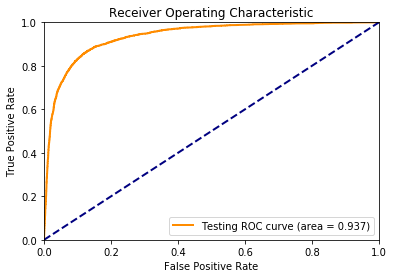

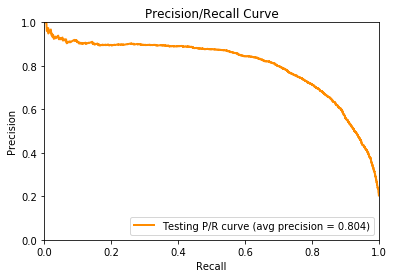

Precision at .9 recall: 0.561
F1 score:  0.76


In [111]:
test_fpr, test_tpr, test_thresholds = roc_curve(test_labels, confs, pos_label=1)
test_roc_auc = auc(test_fpr, test_tpr)

plt.figure()
lw = 2
plt.plot(test_fpr, test_tpr, color='darkorange',
         lw=lw, label='Testing ROC curve (area = %0.3f)' % test_roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

precision, recall, thresholds = precision_recall_curve(test_labels, confs)
avg_prec = average_precision_score(test_labels, confs)

plt.figure()
lw = 2
plt.plot(recall, precision, color='darkorange',
         lw=lw, label='Testing P/R curve (avg precision = %0.3f)' % avg_prec)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision/Recall Curve')
plt.legend(loc="lower right")
plt.show()

r90_index = [i for i, r in enumerate(recall) if r > .9][-1]
p_at_r90 = precision[r90_index]
print('Precision at .9 recall: %0.3f' % p_at_r90)
f1 = [(2 * recall[i] * precision[i]) / (precision[i] + recall[i]) for i in range(len(recall))]
f1 = max(f1)
print('F1 score:  %0.2f' % f1)

In [73]:
model_name = "ft" + str(dim) + ("_%0.3f" % test_roc_auc) + "_all.bin"
model.save_model("../data/models/fastText/classify/" + model_name)

In [ ]:
epochs = [1, 2, 3] + list(range(5, 30, 5))

for e in epochs:
    model = fastText.train_supervised(train_path, dim=300, epoch=e, thread=4, neg=8, lr=0.05, wordNgrams=3)
    predictions = [model.predict(s) for s in test_data]
    confs = [1 - p[1][0] if p[0][0] == '__label__0' else p[1][0] for p in predictions]
    
    fpr, tpr, thresholds = roc_curve(test_labels, confs, pos_label=1)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange', lw=lw, label='Testing ROC curve after ' + str(e) + ' epochs (area = %0.3f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

In [104]:
# Test on external test data
test_path = "../data/processed/processed_reports/zsfg_valid"
test_reports = pickle.load(open(test_path, 'rb'))
shuffle(test_reports)
test_reports = test_reports[:int(len(test_reports) / 4)]
print(len(test_reports))

test_data = [" ".join(t[0]) for t in test_reports]
test_labels = [t[1] for t in test_reports]
print(np.unique(test_labels, return_counts=True))
print(test_data[0])

# Make predictions
confs = [model.predict(s) for s in test_data]

valid_fpr, valid_tpr, valid_thresholds = roc_curve(test_labels, confs, pos_label=1)
valid_roc_auc = auc(valid_fpr, valid_tpr)

20208
(array([0, 1]), array([18094,  2114]))
right breast suspicious bismuth rads 4th recommendations biopsy performed NEGEX_clinical NEGEX_contraindication recommend stereotactic core_needle_biopsy one two groups suspicious amorphous calcifications upper right breast pathophysiologic_finding results sampled group representative 2nd unsampled group findings recommendations discussed PT digital_radiography kumar conclusion exam PT scheduled stereotactic_biopsy letter explaining interpretation lay language_paradigm sent PT


In [105]:
# Test on internal test data
test_path = "../data/processed/processed_reports/ucsf_test_impression"
test_reports = pickle.load(open(test_path, 'rb'))
shuffle(test_reports)
print(len(test_reports))

ucsftest_data = [" ".join(t[0]) for t in test_reports]
ucsftest_labels = [t[1] for t in test_reports]
print(np.unique(test_labels, return_counts=True))
print(test_data[0])

# Make predictions
ucsfconfs = [model.predict(s) for s in ucsftest_data]

ucsf_fpr, ucsf_tpr, ucsf_thresholds = roc_curve(ucsftest_labels, ucsfconfs, pos_label=1)
ucsf_roc_auc = auc(ucsf_fpr, ucsf_tpr)

8779
(array([0, 1]), array([18094,  2114]))
right breast suspicious bismuth rads 4th recommendations biopsy performed NEGEX_clinical NEGEX_contraindication recommend stereotactic core_needle_biopsy one two groups suspicious amorphous calcifications upper right breast pathophysiologic_finding results sampled group representative 2nd unsampled group findings recommendations discussed PT digital_radiography kumar conclusion exam PT scheduled stereotactic_biopsy letter explaining interpretation lay language_paradigm sent PT


/Users/scott/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:2401: UserWarning: Saw kwargs ['lw', 'linewidth'] which are all aliases for 'linewidth'.  Kept value from 'linewidth'
  seen=seen, canon=canonical, used=seen[-1]))


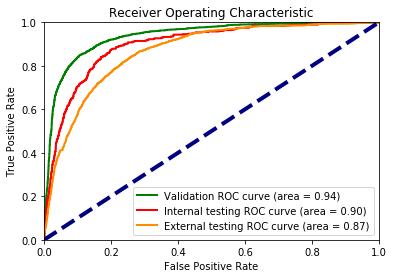

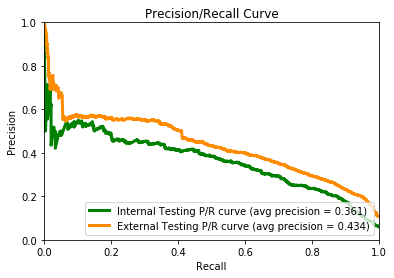

Precision at .9 recall: 0.713
F1 score:  0.82


In [106]:
plt.figure()
lw = 4
plt.plot(test_fpr, test_tpr, color='green', linewidth=2,
         lw=lw, label='Validation ROC curve (area = %0.2f)' % test_roc_auc)
plt.plot(ucsf_fpr, ucsf_tpr, color='red', linewidth=2,
         lw=lw, label='Internal testing ROC curve (area = %0.2f)' % ucsf_roc_auc)
plt.plot(valid_fpr, valid_tpr, color='darkorange', linewidth=2,
         lw=lw, label='External testing ROC curve (area = %0.2f)' % valid_roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.savefig("../data/figures/roc%0.3f.png" % test_roc_auc)
plt.show()

eprecision, erecall, ethresholds = precision_recall_curve(test_labels, confs)
eavg_prec = average_precision_score(test_labels, confs)

iprecision, irecall, ithresholds = precision_recall_curve(ucsftest_labels, ucsfconfs)
iavg_prec = average_precision_score(ucsftest_labels, ucsfconfs)

plt.figure()
lw = 3
plt.plot(irecall, iprecision, color='green',
         lw=lw, label='Internal Testing P/R curve (avg precision = %0.3f)' % iavg_prec)
plt.plot(erecall, eprecision, color='darkorange',
         lw=lw, label='External Testing P/R curve (avg precision = %0.3f)' % eavg_prec)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision/Recall Curve')
plt.legend(loc="lower right")
plt.show()

r90_index = [i for i, r in enumerate(recall) if r > .9][-1]
p_at_r90 = precision[r90_index]
print('Precision at .9 recall: %0.3f' % p_at_r90)
f1 = [(2 * recall[i] * precision[i]) / (precision[i] + recall[i]) for i in range(len(recall))]
f1 = max(f1)
print('F1 score:  %0.2f' % f1)

In [88]:
from end2end_process import EndToEndProcessor
from process_zsfg import get_reports_from_zsfg_csv
import itertools

corpora = ["../../Rnet_files/out_zsfg.csv"]
radlex_path = "../data/processed/radlex_replacements"
data = [get_reports_from_zsfg_csv(ip) for ip in corpora]
merged_data = list(set(list(itertools.chain.from_iterable(data))))
shuffle(merged_data)
merged_data = merged_data

e2e = EndToEndProcessor("../data/processed/clever_replacements", radlex="../data/processed/radlex_replacements")

report_pairs = []
while len(merged_data) > 0:
    labeled_proced = e2e.transform([merged_data[-1]])
    if len(labeled_proced) == 1:
        report_pairs.append((merged_data[-1], labeled_proced[0]))
    merged_data = merged_data[:-1]
shuffle(report_pairs)

mapped_report_strs = []
for mr in report_pairs:
    report_string = " ".join(mr[1][0]).replace("\n", " ")
    label = " __label__" + str(mr[1][1])
    mapped_report_strs.append((mr[0], report_string + label))

test = mapped_report_strs

test_og = [t[0] for t in test]
test_data = [t[1].split("__label__")[0] for t in test]
test_labels = [int(t[1].split("__label__")[1]) for t in test]

class Report():
    def __init__(self, original, data, label):
        self.original = original
        self.data = data
        self.label = label
        prediction = model.predict(data)
        self.conf = 1 - prediction[1][0] if prediction[0][0] == '__label__0' else prediction[1][0]
        self.confusion = (self.label - self.conf) ** 2

report_objs = []
for i in range(len(test)):
    report_objs.append(Report(test_og[i], test_data[i], test_labels[i]))
print(len(report_objs))

TypeError: __init__() got an unexpected keyword argument 'radlex'

In [ ]:
pos_reps = [r for r in report_objs if r.label == 1 and r.conf < 0.8]
neg_reps = [r for r in report_objs if r.label == 0 and r.conf > 0.5]
sorted_pos = sorted(pos_reps, key=lambda x : x.confusion * -1)
sorted_neg = sorted(neg_reps, key=lambda x : x.confusion * -1)

In [ ]:
import csv

with open('../data/zsfg_false_pos.csv', 'w') as csvfile:
    field_names = ["Original Report", "Processed Report", "Ground Truth Label", "Predicted Label"]
    writer = csv.DictWriter(csvfile, fieldnames=field_names)
    writer.writeheader()
    
    for ro in sorted_neg:
        to_write = {}
        to_write["Original Report"] = ro.original
        to_write["Processed Report"] = ro.data
        to_write["Ground Truth Label"] = ro.label
        to_write["Predicted Label"] = ro.conf
        writer.writerow(to_write)

with open('../data/zsfg_false_neg.csv', 'w') as csvfile:
    field_names = ["Original Report", "Processed Report", "Ground Truth Label", "Predicted Label"]
    writer = csv.DictWriter(csvfile, fieldnames=field_names)
    writer.writeheader()
    
    for ro in sorted_pos:
        to_write = {}
        to_write["Original Report"] = ro.original
        to_write["Processed Report"] = ro.data
        to_write["Ground Truth Label"] = ro.label
        to_write["Predicted Label"] = ro.conf
        writer.writerow(to_write)
        
with open('../data/zsfg_all.csv', 'w') as csvfile:
    field_names = ["Original Report", "Processed Report", "Ground Truth Label", "Predicted Label"]
    writer = csv.DictWriter(csvfile, fieldnames=field_names)
    writer.writeheader()
    
    for ro in report_objs:
        to_write = {}
        to_write["Original Report"] = ro.original
        to_write["Processed Report"] = ro.data
        to_write["Ground Truth Label"] = ro.label
        to_write["Predicted Label"] = ro.conf
        writer.writerow(to_write)

In [ ]:
# Write test UCSF examples
from preprocessing import get_reports_from_csv


corpora = ["../../report_csvs/ucsf_test.csv"]
radlex_path = "../data/processed/radlex_replacements"
data = [get_reports_from_csv(ip) for ip in corpora]
merged_data = list(set(list(itertools.chain.from_iterable(data))))
shuffle(merged_data)
merged_data = merged_data

e2e = EndToEndProcessor("../data/processed/clever_replacements", radlex="../data/processed/radlex_replacements")

report_pairs = []
while len(merged_data) > 0:
    labeled_proced = e2e.transform([merged_data[-1]])
    if len(labeled_proced) == 1:
        report_pairs.append((merged_data[-1], labeled_proced[0]))
    merged_data = merged_data[:-1]
shuffle(report_pairs)

mapped_report_strs = []
for mr in report_pairs:
    report_string = " ".join(mr[1][0]).replace("\n", " ")
    label = " __label__" + str(mr[1][1])
    mapped_report_strs.append((mr[0], report_string + label))

test = mapped_report_strs

test_og = [t[0] for t in test]
test_data = [t[1].split("__label__")[0] for t in test]
test_labels = [int(t[1].split("__label__")[1]) for t in test]

report_objs = []
for i in range(len(test)):
    report_objs.append(Report(test_og[i], test_data[i], test_labels[i]))
print(len(report_objs))

In [ ]:
import csv

with open('../data/ucsf_test.csv', 'w') as csvfile:
    field_names = ["Original Report", "Processed Report", "Ground Truth Label", "Predicted Label"]
    writer = csv.DictWriter(csvfile, fieldnames=field_names)
    writer.writeheader()
    
    for ro in report_objs:
        to_write = {}
        to_write["Original Report"] = ro.original
        to_write["Processed Report"] = ro.data
        to_write["Ground Truth Label"] = ro.label
        to_write["Predicted Label"] = '%0.3f' % ro.conf
        writer.writerow(to_write)

In [ ]:
# Write all UCSF examples
from preprocessing import get_reports_from_csv


corpora = ["../../Rnet_files/positive_examples.csv", "../../Rnet_files/random_examples.csv", "../../Rnet_files/20170305-20170311RadReport.csv"]
radlex_path = "../data/processed/radlex_replacements"
data = [get_reports_from_csv(ip) for ip in corpora]
merged_data = list(set(list(itertools.chain.from_iterable(data))))
shuffle(merged_data)
merged_data = merged_data

e2e = EndToEndProcessor("../data/processed/clever_replacements", radlex="../data/processed/radlex_replacements")

report_pairs = []
while len(merged_data) > 0:
    labeled_proced = e2e.transform([merged_data[-1]])
    if len(labeled_proced) == 1:
        report_pairs.append((merged_data[-1], labeled_proced[0]))
    merged_data = merged_data[:-1]
shuffle(report_pairs)

mapped_report_strs = []
for mr in report_pairs:
    report_string = " ".join(mr[1][0]).replace("\n", " ")
    label = " __label__" + str(mr[1][1])
    mapped_report_strs.append((mr[0], report_string + label))

test = mapped_report_strs

test_og = [t[0] for t in test]
test_data = [t[1].split("__label__")[0] for t in test]
test_labels = [int(t[1].split("__label__")[1]) for t in test]

report_objs = []
for i in range(len(test)):
    report_objs.append(Report(test_og[i], test_data[i], test_labels[i]))
print(len(report_objs))

In [ ]:
with open('../data/ucsf_all.csv', 'w') as csvfile:
    field_names = ["Original Report", "Processed Report", "Ground Truth Label", "Predicted Label"]
    writer = csv.DictWriter(csvfile, fieldnames=field_names)
    writer.writeheader()
    
    for ro in report_objs:
        to_write = {}
        to_write["Original Report"] = ro.original
        to_write["Processed Report"] = ro.data
        to_write["Ground Truth Label"] = ro.label
        to_write["Predicted Label"] = '%0.3f' % ro.conf
        writer.writerow(to_write)